In [1]:
from ML_Preparation.Preprocessing_M import DataExtractor, DataPreprocessing

de = DataExtractor("D:/hka-aqm-m", "C:/Users/danie/building_M_data")

df = de.create_df()

No .dat files found in C:/Users/danie/building_M_data. 
 Trying to extract files from the original directory D:/hka-aqm-m
Read data successfully.
Data contains 979166 data points and 18 columns.


In [2]:
dp = DataPreprocessing()

df_preprocessed = dp.preprocess_df(df, rolling_window = "7d", sample_time = "1d")

In [3]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'rssi',
       'snr', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'room_number', 'time_diff_sec', 'hum_diff', 'CO2_diff', 'VOC_diff',
       'vis_diff', 'IR_diff', 'BLE_diff', 'tavg_diff', 'tmin_diff',
       'tmax_diff', 'prcp_diff', 'wdir_diff', 'wspd_diff', 'wpgt_diff',
       'pres_diff', 'time_diff_sec_per_sec', 'hum_diff_per_sec',
       'CO2_diff_per_sec', 'VOC_diff_per_sec', 'vis_diff_per_sec',
       'IR_diff_per_sec', 'BLE_diff_per_sec', 'tavg_diff_per_sec',
       'tmin_diff_per_sec', 'tmax_diff_per_sec', 'prcp_diff_per_sec',
       'wdir_diff_per_sec', 'wspd_diff_per_sec', 'wpgt_diff_per_sec',
       'pres_diff_per_sec', 'year', 'dayofweek', 'hour', 'season', 'color',
       'VOC_CO2_ratio'],
      dtype='object')

In [35]:
from ML_Preparation.Feature_Engineering import *

fe = FeatureEngineering(df_preprocessed.drop(columns = ["CO2_diff", "CO2_diff_per_sec", "VOC_CO2_ratio"]), 
                        label = "CO2", 
                        categorical_features = ["season", "room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train, y_train, X_test, y_test = fe.feature_engineering(skip_scale = True)

In [36]:
df_train = fe.X_train
df_train["CO2"] = fe.y_train

df_test = fe.X_test
df_test["CO2"] = fe.y_test

In [37]:
def transform_data_for_forecasting(data, label_name, n_in, n_out, dropna = True):
    n_vars = data.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data[[f"{label_name}"]].shift(-i))
        if i == 0:
            names += [f"{label_name}(t)"]
        else:
            names += [f"{label_name}(t+{i})"]
        # put it all together
        data_reframed = pd.concat(cols, axis=1)
        data_reframed.columns = names
        # drop rows with NaN values
        if dropna:
            data_reframed.dropna(inplace=True)

    return data_reframed

In [38]:
train_reframed = transform_data_for_forecasting(df_train, "CO2", 1, 1)
test_reframed = transform_data_for_forecasting(df_test, "CO2", 1, 1)

In [39]:
train_reframed

,tmp(t-1),hum(t-1),VOC(t-1),vis(t-1),IR(t-1),BLE(t-1),tavg(t-1),tmin(t-1),tmax(t-1),prcp(t-1),...,dayofweek_2(t-1),dayofweek_3(t-1),dayofweek_4(t-1),dayofweek_5(t-1),dayofweek_6(t-1),color_green(t-1),color_red(t-1),color_yellow(t-1),CO2(t-1),CO2(t)
date_time,,,,,,,,,,,,,,,,,,,,,
2022-06-03,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,False,True,False,False,False,True,False,False,538.500000,538.500000
2022-06-04,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,False,False,True,False,False,True,False,False,538.500000,538.500000
2022-06-05,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,False,False,False,True,False,True,False,False,538.500000,538.500000
2022-06-06,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,False,False,False,False,True,True,False,False,538.500000,538.500000
2022-06-07,25.167642,33.097784,450.531250,124.801136,49.480114,11.900568,15.75,11.1,20.15,0.0,...,False,False,False,False,False,True,False,False,538.500000,538.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-28,28.152657,37.309881,1333.190754,500.872343,216.117433,7.104621,16.10,11.2,20.70,0.0,...,True,False,False,False,False,True,False,False,443.491164,439.589578
2023-06-28,29.611006,39.836299,1516.162335,245.011110,76.894413,3.425267,16.10,11.2,20.70,0.0,...,True,False,False,False,False,True,False,False,439.589578,479.273107
2023-06-28,28.622999,42.490604,1158.198388,100.615457,36.376964,3.960301,16.10,11.2,20.70,0.0,...,True,False,False,False,False,True,False,False,479.273107,617.419709


In [40]:
df_train.tail()["CO2"]

date_time
2023-06-28    439.589578
2023-06-28    479.273107
2023-06-28    617.419709
2023-06-28    560.124293
2023-06-28    433.645297
Name: CO2, dtype: float64

In [41]:
from sklearn.preprocessing import StandardScaler

def transform_to_numpy_array(train_data, test_data, n_out):
    # split into train and test sets
    values_train = train_data.values
    values_test = test_data.values
    # split into input and outputs
    train = values_train[:, :]
    test = values_test[:, :]

    train_X, train_y = train[:, :-n_out], train[:, -n_out:]
    test_X, test_y = test[:, :-n_out], test[:, -n_out:]

    sc = StandardScaler()

    train_X = sc.fit_transform(train_X)
    test_X = sc.transform(test_X)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    train_X = np.asarray(train_X).astype('float32')
    train_y = np.asarray(train_y).astype('float32')

    test_X = np.asarray(test_X).astype('float32')
    test_y = np.asarray(test_y).astype('float32')

    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = transform_to_numpy_array(train_reframed, test_reframed, 1)


(5679, 1, 85) (5679, 1) (1419, 1, 85) (1419, 1)


In [42]:
train_X.shape

(5679, 1, 85)

Epoch 1/10


c:\Users\danie\anaconda3\envs\awp1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 - 3s - 15ms/step - loss: 92449.0781
Epoch 2/10
178/178 - 0s - 1ms/step - loss: 74356.5312
Epoch 3/10
178/178 - 0s - 1ms/step - loss: 68817.9766
Epoch 4/10
178/178 - 0s - 1ms/step - loss: 68234.5000
Epoch 5/10
178/178 - 0s - 1ms/step - loss: 62276.4102
Epoch 6/10
178/178 - 0s - 1ms/step - loss: 57780.6289
Epoch 7/10
178/178 - 0s - 1ms/step - loss: 50646.6289
Epoch 8/10
178/178 - 0s - 1ms/step - loss: 50039.8984
Epoch 9/10
178/178 - 0s - 1ms/step - loss: 50547.3711
Epoch 10/10
178/178 - 0s - 1ms/step - loss: 48677.3828


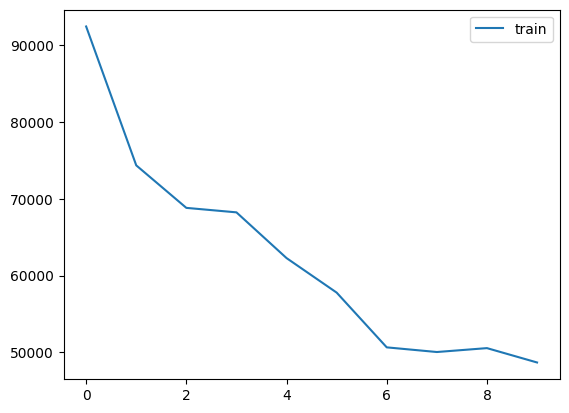

In [43]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.optimizers import Adam, SGD
from matplotlib import pyplot

class MyLSTMModel:
    def __init__(self,
                 n_out, 
                 lstm_units=100,
                 input_shape=(None, train_X.shape[-1]),
                 ):
        self.model = Sequential()
        self.model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences = True, recurrent_dropout = 0.3))
        self.model.add(Dropout(0.3))
        self.model.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout = 0.3)))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(15, activation = "relu"))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(n_out))

        self.model.compile(optimizer=Adam(learning_rate = 0.05), loss='mse')
    
    def summary(self):
        self.model.summary()

# Instantiate the model
my_model = MyLSTMModel(1)

history = my_model.model.fit(train_X, train_y, epochs=10, batch_size=32, 
                             #validation_data=(test_X, test_y), 
                             verbose=2, shuffle=False)

pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [44]:
pred = my_model.model.predict(test_X)

# pred = pd.DataFrame(pred, columns = ["pred_CO2(t)"])

# pred["CO2(t)"] = test_y
pred

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[458.06796],
       [458.06796],
       [458.06796],
       ...,
       [458.06796],
       [458.06796],
       [458.06796]], dtype=float32)

In [224]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score


class Evaluator:

    def __init__(self):
        pass

    def evaluate(self, y_pred, y_true):
        print("MSE: ", self.calculate_mse(y_pred = y_pred, y_true = y_true))
        print("RMSE: ", self.calculate_rmse(y_pred = y_pred, y_true = y_true))
        print("MAPE: ", self.calculate_mape(y_pred = y_pred, y_true = y_true))
        print("R2: ", self.calculate_r2(y_pred = y_pred, y_true = y_true))
        print("\n")


    def calculate_mse(self, y_true, y_pred):
        return round(mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_rmse(self, y_true, y_pred):
        return round(root_mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_mape(self, y_true, y_pred):
        return round(mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_r2(self, y_true, y_pred):
        return round(r2_score(y_true = y_true, y_pred = y_pred), 2)

ev = Evaluator()
